# Movie Rating Prediction with IMDb Dataset
Yipeng Han

## 1. Importing Libraries and Loading Data

In [1]:
import gc
gc.enable()
from collections import Counter
import os
os.chdir('D://Interview Question//Interview Question//audible')
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import RandomNormal
from keras.optimizers import adam, Adadelta
from keras import regularizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [13]:
akas = dd.from_pandas(pd.read_csv('title.akas.tsv//data.tsv', sep='\t'),
                      npartitions=3)
crew = dd.read_csv('title.crew.tsv//data.tsv', sep='\t')
# No need to load this data becuase it relates to tv series only
#episode = dd.read_csv('title.episode.tsv//data.tsv',sep='\t')
name = dd.read_csv('name.basics.tsv//data.tsv', sep='\t')
title = dd.from_pandas(pd.read_csv('title.basics.tsv//data.tsv', sep='\t'),
                       npartitions=3)
principal = dd.read_csv('title.principals.tsv//data.tsv', sep='\t')
rating = dd.read_csv('title.ratings.tsv//data.tsv', sep='\t')

# Select only movies
title = title[title['titleType'] == 'movie']
title = title[title['startYear'] != '\\N']
title['startYear'] = title['startYear'].astype(np.int64)


df = title.merge(akas, how='left', left_on='tconst', right_on='titleId')
df = df.merge(rating, how='inner', left_on='tconst', right_on='tconst')

In [3]:
df.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1171707 entries, 0 to 390428
Data columns (total 19 columns):
tconst             1171707 non-null object
titleType          1171707 non-null object
primaryTitle       1171707 non-null object
originalTitle      1171707 non-null object
isAdult            1171707 non-null int64
startYear          1171707 non-null int64
endYear            1171707 non-null object
runtimeMinutes     1171707 non-null object
genres             1171707 non-null object
titleId            1157613 non-null object
ordering           1157613 non-null float64
title              1157613 non-null object
region             1157609 non-null object
language           1157613 non-null object
types              1157613 non-null object
attributes         1157613 non-null object
isOriginalTitle    1157613 non-null object
averageRating      1171707 non-null float64
numVotes           1171707 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 178.8+ MB


In [4]:
# this is basic table contains all movie related info
df.compute().head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,tt5627502,movie,The Harvesters,The Harvesters,0,2017,\N,91,Horror,tt5627502,1.0,The Harvesters,US,\N,\N,\N,0,4.1,27
1,tt5628012,movie,The Bacchus Lady,Jug-yeo-ju-neun Yeo-ja,0,2016,\N,110,Drama,tt5628012,1.0,Jug-yeo-ju-neun Yeo-ja,KR,\N,\N,\N,0,7.2,296
2,tt5628012,movie,The Bacchus Lady,Jug-yeo-ju-neun Yeo-ja,0,2016,\N,110,Drama,tt5628012,2.0,Jug-yeo-ju-neun Yeo-ja,\N,\N,original,\N,1,7.2,296
3,tt5628012,movie,The Bacchus Lady,Jug-yeo-ju-neun Yeo-ja,0,2016,\N,110,Drama,tt5628012,3.0,The Bacchus Lady,XWW,en,imdbDisplay,\N,0,7.2,296
4,tt5628012,movie,The Bacchus Lady,Jug-yeo-ju-neun Yeo-ja,0,2016,\N,110,Drama,tt5628012,4.0,A Dama de Baco,BR,\N,imdbDisplay,\N,0,7.2,296
5,tt5628012,movie,The Bacchus Lady,Jug-yeo-ju-neun Yeo-ja,0,2016,\N,110,Drama,tt5628012,5.0,The Bacchus Lady,FR,\N,imdbDisplay,\N,0,7.2,296
6,tt5628688,movie,Par instinct,Par instinct,0,2017,\N,83,"Adventure,Drama",tt5628688,1.0,Par instinct,FR,\N,\N,\N,0,5.1,78
7,tt5628688,movie,Par instinct,Par instinct,0,2017,\N,83,"Adventure,Drama",tt5628688,2.0,Par instinct,\N,\N,original,\N,1,5.1,78
8,tt5628688,movie,Par instinct,Par instinct,0,2017,\N,83,"Adventure,Drama",tt5628688,3.0,Love is what we need,\N,\N,\N,\N,0,5.1,78
9,tt5628792,movie,I Got Life!,Aurore,0,2017,\N,89,"Comedy,Drama",tt5628792,10.0,Pomlad pri petdesetih,SI,\N,imdbDisplay,\N,0,6.3,832


## Exploratory Data Analysis and Assumption

### Assumption 1: Is movie rating related with number of votes?
- To answer this question through graph, I use quartile of numVote to cut it into 4 groups. Within each group, we could calculate a average rating for all movies in inside this group. From the plot, it cannot prove the first assumption.

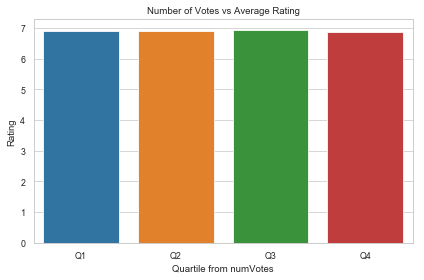

In [4]:
qcut_rating = rating.copy().compute()
qcut_rating['cut'] = pd.qcut(qcut_rating ['numVotes'],q = [0, .25, .5, .75, 1.],labels = ["Q1",'Q2','Q3','Q4'])
d = {'mean':'Average'}
qcut_rating = qcut_rating.groupby('cut')['averageRating'].agg(['mean']).rename(columns=d)
g = sns.barplot(x = qcut_rating.index, y = 'Average',data = qcut_rating).set_title('Number of Votes vs Average Rating')
plt.xlabel('Quartile from numVotes')
plt.ylabel('Rating')
plt.tight_layout()
plt.show(g)

### Assumption 2: Is movie rating related with movie genre?
- For this assumption, group all movies based on “genre” and calculate mean of “averageRating” for each group. Note that a movie might has more than one genre, e.g. drama and adventure. In this case, we will double count it. 

- Based on this plot, there are some genres that have high score than others, which mean that genre definitely affect the movie rating.

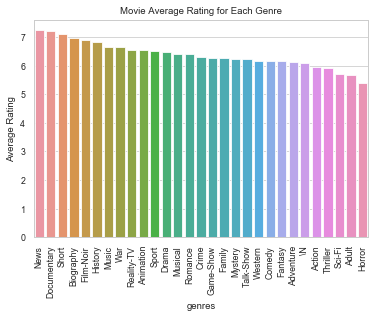

In [5]:
average_rating = df[['genres','averageRating']].dropna(subset=['genres']).reset_index(drop=True).compute()
splitted = average_rating['genres'].str.split(',').reset_index()
l = splitted['genres'].str.len()
average_rating = pd.DataFrame(data={'average_rating': np.repeat(average_rating['averageRating'], l),
                                   'genres':np.concatenate(splitted['genres'])}) 
d = {'mean':'Average'}
average = average_rating.groupby('genres')['average_rating'].agg(['mean']).rename(columns=d).sort_values(by = 'Average',ascending=False)
sns.barplot(x = average.index, y = 'Average',data = average,capsize=.2)
plt.xticks(rotation=90)
plt.title('Movie Average Rating for Each Genre')
plt.ylabel('Average Rating')
plt.show()

The following plot shows the rating speard for each genre. Generally, most genres' rating are well spreaded.

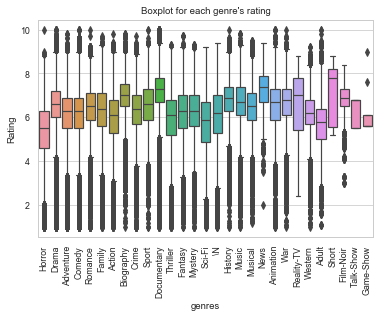

In [6]:
sns.boxplot(x = 'genres',y='average_rating',data = average_rating)
plt.xticks(rotation=90)
plt.title('Boxplot for each genre\'s rating')
plt.ylabel('Rating')
plt.show()

### Assumption 3: Is movie rating related with movie startYear?

- For this assumption, I find all movie ratings given their startYear. For visualization purpose, I choose all movies with start Year after 1960.

- The color of the bar shows the mean rating for that year comparing to others. The darker, the higher rating. It shows a interesting trend from high to low, and to high again. This trend supports the deletion of all movies without startYear.



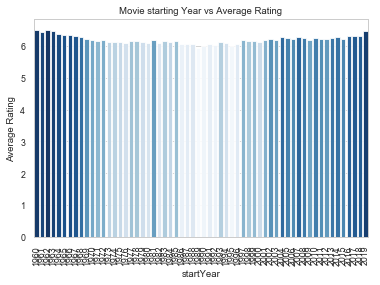

In [11]:
year = df[['startYear','averageRating']].dropna(subset=['startYear']).reset_index(drop=True).compute()
# for visualization purpose, take all movie with startYear after 1960
year = year[year['startYear']>=1960]
d = {'mean':'Average'}
year_average = year.groupby('startYear')['averageRating'].agg(['mean']).rename(columns=d)
rank = year_average["Average"].argsort().argsort() 
pal = sns.color_palette("Blues", len(year_average))
sns.barplot(x = year_average.index, y = 'Average',data = year_average, palette=np.array(pal[::])[rank])
plt.xticks(rotation=90)
plt.title('Movie starting Year vs Average Rating')
plt.ylabel('Average Rating')
plt.show()

Column 'ordering' is a really special feature here, because it links 'same' movies with different region/ language together. So it controls movie version count. In order to reduce dimension of dataset, I choose only original movies. But this version count is saved as one feature.

In [5]:
# columns 'ordering'
number_different_version = df.compute().groupby('titleId').agg('max')['ordering']
# pick all movies with ordering 1
df = df[df['ordering'] == 1]

For the following plot, I want to see the distribution of ordering. If there exists a high ordering except 1, I should not extract only movie with ordering 1

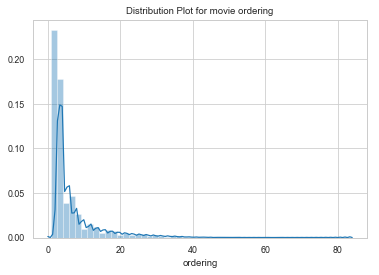

In [6]:
sns.distplot(number_different_version)
plt.title('Distribution Plot for movie ordering')
plt.show()

Because of the limited memory, I could not merge the cast info (Pincipal) with df. I comment code for merging them.

In [15]:
# merge crew data
df = df.merge(crew, how='left', left_on='tconst', right_on='tconst')
# select major director and writer
df['directors'] = df['directors'].str.split(',')
df['directors'] = df['directors'].apply(lambda x: x[0])
df['writers'] = df['writers'].str.split(',')
df['writers'] = df['writers'].apply(lambda x: x[0])

# add prefix to seperate director and writer
df = df.merge(name.compute().add_prefix('director_').fillna('N/A'),
              how='left',
              left_on='directors',
              right_on='director_nconst')
df = df.merge(name.compute().add_prefix('writer_').fillna('N/A'),
              how='left',
              left_on='directors',
              right_on='writer_nconst')
#gc.collect()
# Add Pincipal cast data
#principal = principal.merge(name, how='left', on='nconst')
#actor = principal[principal['category'] == 'actor'].compute().add_prefix(
#    'actor_')
#gc.collect()
#actress = principal[principal['category'] == 'actress'].compute().add_prefix(
#    'actress_')
#gc.collect()
#df = df.merge(actor, how='left', left_on='tconst', right_on='actor_tconst')
#df = df.merge(actress, how='left', left_on='tconst', right_on='actress_tconst')

In [16]:
# create temp table contains only movies and ratings
rating_for_titles = rating[['tconst', 'averageRating']].compute()
rating_for_titles.set_index('tconst', inplace=True)

df = df.compute()
def average_relating_func(x,string = 'director'):
    '''Returning mean rating for this individual\'s relating work'''
    temp=0
    count=0
    for i in x[string+'_knownForTitles']:
        if i in rating_for_titles.index:
            temp+=rating_for_titles.loc[i]['averageRating']
            count+=1
    if count == 0:
        return 0
    else:
        return temp/count
    
df['director_knownForTitles'] = df['director_knownForTitles'].str.split(',')
df['director_score'] = 0
df['director_knownForTitles'] = df['director_knownForTitles'].fillna('N/A')
df['director_score'] = df.apply(lambda x: average_relating_func(x,string='director'),axis=1)

df['writer_knownForTitles'] = df['writer_knownForTitles'].str.split(',')
df['writer_score'] = 0
df['writer_knownForTitles'] = df['writer_knownForTitles'].fillna('N/A')
df['writer_score'] = df.apply(lambda x: average_relating_func(x,string = 'writer'),axis=1)

With the code in comment, actor / actress average relating rate could be added.

In [ ]:
#df['actor_knownForTitles'] = df['actor_knownForTitles'].str.split(',')
#df['actor_score'] = 0
#df['actor_knownForTitles'] = df['actor_knownForTitles'].fillna('N/A')
#df['actor_score'] = df.apply(lambda x: average_relating_func(x,string='actor'),axis=1)

#df['actress_knownForTitles'] = df['actress_knownForTitles'].str.split(',')
#df['actress_score'] = 0
#df['actress_knownForTitles'] = df['actress_knownForTitles'].fillna('N/A')
#df['actress_score'] = df.apply(lambda x: average_relating_func(x,string='director'),axis=1)

The plot below shows the distribution for director's relating titles' mean rating. From this plot, we could tell that most directors have a mean of 6 ~ 8 and there are some directors who don't have other movies so that they get average rating of 0

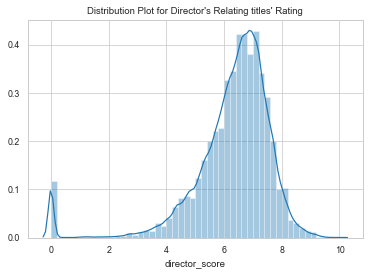

In [18]:
sns.distplot(df['director_score'])
plt.title('Distribution Plot for Director\'s Relating titles\' Rating')
plt.show()

In [19]:
# Column 'isOriginalTitle' has only 1 null, so just fill 0
df['isOriginalTitle'] = df['isOriginalTitle'].apply(lambda x: int(x)
                                                    if x != '\\N' else np.nan)
df['isOriginalTitle'] = df['isOriginalTitle'].fillna(0)

# Column 'runtimeMinutes' is numeric data, fillna with column mean
df['runtimeMinutes'] = df['runtimeMinutes'].apply(lambda x: int(x)
                                                  if x != '\\N' else np.nan)
df['runtimeMinutes'] = df['runtimeMinutes'].fillna(df['runtimeMinutes'].mean())

# Columns 'genres' transform into dummies
genres_feature = df['genres'].str.get_dummies(',').reset_index(drop=True)

# Columns 'region' transform into categorical with top 30 region selected
df['region'] = df['region'].apply(lambda x: x
                                  if x != '\\N' else 'Other Regions')
df['region'] = df['region'].apply(lambda x: 'region_' + str(x))
count = Counter()
for coord in df['region']:
    count[coord] += 1
region_feature_list = [i for i, num in count.most_common(30)]
df['region'] = df['region'].apply(lambda x: x
                                  if x in region_feature_list else 'Region_nan')
region_feature = df['region'].str.get_dummies().reset_index(drop=True)

# Column 'Type' transform into dummies
df['types'] = df['types'].apply(lambda x: x if x != '\\N' else 'Other Types')
types_feature = df['types'].str.get_dummies().reset_index(drop=True)

def year_check(string):
    '''
    Input: year(string) 
    Check birthyear is before 70s or after 70s
    '''
    if string == 'BirthYear_Unknown':
        return string
    return 'Before 70s' if int(string) <= 1970 else 'After 70s'


# For director and writer BirthYear, transform into categorical variable
df['director_birthYear'] = df['director_birthYear'].apply(
    lambda x: x if x != '\\N' else 'BirthYear_Unknown')
df['director_birthYear'] = df['director_birthYear'].fillna('BirthYear_Unknown')
df['director_birthYear'] = df['director_birthYear'].apply(year_check)
director_birthYear_feature = df['director_birthYear'].str.get_dummies(
).add_prefix('Director_').reset_index(drop=True)

df['writer_birthYear'] = df['writer_birthYear'].apply(lambda x: x if x != '\\N'
                                                      else 'BirthYear_Unknown')
df['writer_birthYear'] = df['writer_birthYear'].fillna('BirthYear_Unknown')
df['writer_birthYear'] = df['writer_birthYear'].apply(year_check)
writer_birthYear_feature = df['writer_birthYear'].str.get_dummies().add_prefix(
    'Writer_').reset_index(drop=True)

# Columns 'primaryProfession' transform into dummies
director_profession_feature = df['director_primaryProfession'].str.get_dummies(
    ',').reset_index(drop=True)
writer_profession_feature = df['writer_primaryProfession'].str.get_dummies(
    ',').reset_index(drop=True)

In the code above, I set birthYear into categorical data with 1970 as a midpoint, which is also the approximate median of all available birthYear features. And for region, the threshold 30 is getting from including half of the region count.

In [20]:
# remove attribute because it contains too many empty
drop_columns = ['titleType','primaryTitle', 'originalTitle','titleId','ordering',
                'genres', 'title','types','endYear','ordering','region','language'
                ,'attributes', 'directors', 'writers',
       'director_nconst', 'director_primaryName', 'director_birthYear',
       'director_deathYear', 'director_primaryProfession',
       'director_knownForTitles', 'writer_nconst', 'writer_primaryName',
       'writer_birthYear', 'writer_deathYear', 'writer_primaryProfession',
       'writer_knownForTitles']
# remove columns
df = df.drop(columns = drop_columns)

# merge feature data with df
df = df.reset_index(drop=True)
df = pd.concat([df,genres_feature,region_feature,types_feature,
                director_birthYear_feature,writer_birthYear_feature,director_profession_feature,
                writer_profession_feature],axis = 1)

df = pd.merge(df,number_different_version, how= 'left',left_on='tconst',right_on=number_different_version.index)

## 3. Data Standardization
Before going into model building, we want to make sure our data is standardized so that it improves training process. Here, since most of the features are dummies. We don't need to worry too much about them. Only numeric data needs standardized in this case.

In [21]:
# standardize
Scaler = StandardScaler()
df['runtimeMinutes'] = Scaler.fit_transform(df[['runtimeMinutes']].values)
df['startYear'] = MinMaxScaler().fit_transform(df[['startYear']].values)
df['numVotes'] = Scaler.fit_transform(df[['numVotes']].values)
df['director_score'] = Scaler.fit_transform(df[['director_score']].values)
df['writer_score'] = Scaler.fit_transform(df[['writer_score']].values)
df['ordering'] = Scaler.fit_transform(df[['ordering']].values)

# Selecting target and feature data
df.index = df['tconst']
target = df['averageRating']
df = df.drop(columns = ['tconst','averageRating'])

Following plot is the correlation map, from the plot, we could tell that there are several features correlated with each other. As a result, we have to remove them.

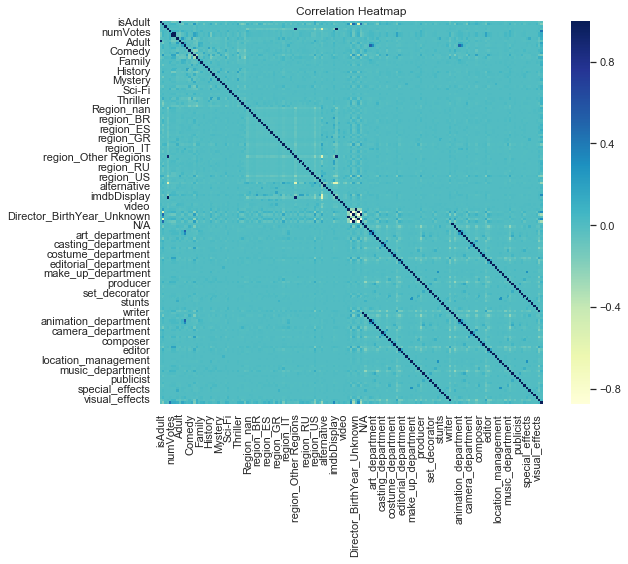

In [26]:
sns.set(rc={'figure.figsize': (10, 8)})
corr = df.corr()
sns.heatmap(corr, cbar=True, fmt='.2f', annot_kws={'size': 3}, square=True, cmap="YlGnBu")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

The following two functions provides the tool to find the high absolute correlated pair of features. And remove one feature of each pair from our data 

In [27]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    ''' return top correlated pair'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Top Absolute Correlations
isOriginalTitle             original                      1.000000
Director_BirthYear_Unknown  Writer_BirthYear_Unknown      1.000000
Director_After 70s          Writer_After 70s              1.000000
Director_Before 70s         Writer_Before 70s             1.000000
director_score              writer_score                  1.000000
isAdult                     Adult                         0.955626
isOriginalTitle             region_Other Regions          0.934954
region_Other Regions        original                      0.934954
Director_Before 70s         Director_BirthYear_Unknown    0.876154
                            Writer_BirthYear_Unknown      0.876154
dtype: float64


In [29]:
# remove the high correlated columns
high_correlated_pair = [
    'Writer_After 70s', 'Writer_BirthYear_Unknown', 'Writer_Before 70s',
    'writer_score', 'original', 'Adult', 'isOriginalTitle'
]
df = df.drop(columns=high_correlated_pair)

## 4. Create training set and test set
In this section, I split the data into training and test set and implement a SVD to add some features with the original data.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    target.values,
                                                    test_size=0.2,
                                                    random_state=20)

#### Using SVD to generate new features

In [31]:
K = 75 # choose 75 for getting enough explained variation
svd = TruncatedSVD(n_components = K,random_state=0)
SVD_x = svd.fit(X_train)
perc=SVD_x.explained_variance_ratio_.cumsum()[K-1]
print("Cumulative explained variation: " + "{:.2%}".format(perc))
X_train =np.concatenate((X_train,SVD_x.transform(X_train)),axis=1)
X_test = np.concatenate((X_test,SVD_x.transform(X_test)),axis=1)

Cumulative explained variation: 98.52%


## 5. Model Building

### ElasticNet Regression
- For this regression/prediction task, I choose using MSE as loss metric.

- First model I use is ElasticNet regression. I use a Kfold CV checking MSE for a set of alphas to find the optimal hyperparameter. And with the best alpha, we run on both training and testing.

- $MSE_{training} = 1.15993$  and  $MSE_{test} = 1.16147$

Text(0, 0.5, 'mse')

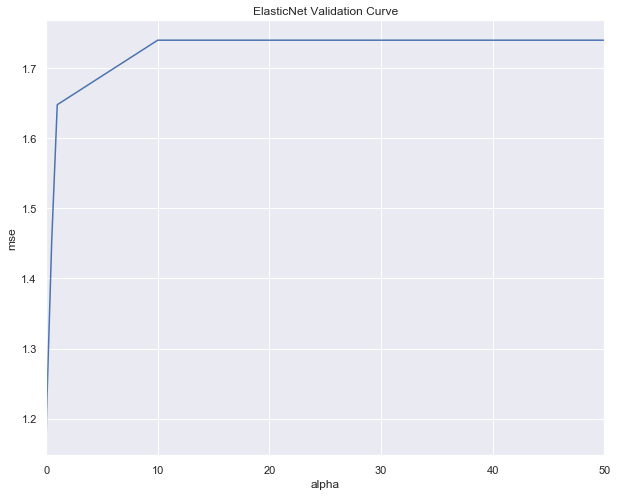

In [32]:
def k_mse_cv(model, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    mse = -(cross_val_score(
        model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (mse)


model_elasticNet = ElasticNet(l1_ratio=0.5)
# Tunning hyperparameter
alphas = [0.01, 0.05, 0.5, 1, 10, 50]
cv_elasticNet = [k_mse_cv(ElasticNet(alpha=alpha)).mean() for alpha in alphas]
cv_elasticNet = pd.Series(cv_elasticNet, index=alphas)

# plot CV
cv_elasticNet.plot(title="ElasticNet Validation Curve")
plt.xlabel("alpha")
plt.ylabel("mse")

In [41]:
# using elastic net with the tunned hyperparater and calculate MSE with test set
elastic = ElasticNet(alpha=0.01, random_state=42)
mse = -(cross_val_score(elastic, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
print("ElasticNet Kfold CV MSE: %0.5f (+/- %0.2f)" % (mse.mean(), mse.std() * 2))
elastic.fit(X_train, y_train)

print('ElasticNet test MSE:%0.5f' % (mean_squared_error(y_test,elastic.predict(X_test))))

ElasticNet Kfold CV MSE: 1.15993 (+/- 0.02)
ElasticNet test MSE:1.16147


### Random Forest Regressor
- Second model I use is Random Forest Regressor with a gridsearch to find the optimal set of hyperparameters.
- With the best set of hyperparameter, $MSE_{training} = 0.97662$  and  $MSE_{test} = 0.97671$.

- It performs slightly better than the ElasticNet Regressor.


In [37]:
# Random Forest regressor
# GridSearch to find the best hyperparameter
rf = RandomForestRegressor()
parameters = {'n_estimators': [10,25], 
              'max_depth': [2, 5], 
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 5],
              'oob_score': [True],
             }
grid_rf = GridSearchCV(estimator= rf,param_grid=parameters,cv=5, verbose =1,scoring="neg_mean_squared_error")
grid_rf = grid_rf.fit(X_train,y_train)
rf = grid_rf.best_estimator_
# Best Model: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 25, 'oob_score': True}

print(grid_rf.best_params_ )
print(-(grid_rf.best_score_))
rf.fit(X_train,y_train)

print(mean_squared_error(y_test,rf.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 62.3min finished


{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 25, 'oob_score': True}
0.9766227805199476
0.9767128004460867


#### Random Forest Feature Importance

From the random forest feature importance, the top 3 features:
 - director_score
 - Documentary
 - Horror
 
They are reasonable for the following reason. First, director_score represents the average rating of a director's work, which might infer the rating of his other works. The second important feature and third one belong to genres, which is already shown in the plot from EDA section.

In [62]:
names = df.columns
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)[:8])

Features sorted by their score:
[(0.6887, 'director_score'), (0.045, 'Documentary'), (0.0107, 'Horror'), (0.0088, 'Drama'), (0.0049, 'Director_Before 70s'), (0.0039, 'startYear'), (0.0026, 'numVotes'), (0.0004, 'Director_BirthYear_Unknown')]


## 6. Conclusion
- In this project, I use IMDb data set to predict movie rating with two machine learning model, Elastic Net and Random Forest. From the result performance, Random Forest beats Elastic Net regression. But for aspect of running time, random forest takes much longer than Elastic Net.

- The Director past/relevant works’ rating is a strong indicator of movie rating, shown by the random forest regressor.

- Similar to director, actor/actress relevant score should also be relevent and important. However, due to the memory limit, I have to skip the cast information.


## 7. Additional Research
- Beside ElasticNet regression and random forest regressor, I try the data with a simple neural network with 3 layer using normal initializer. However, after running several settings, I find that it overfits really fast even with the simple network. 

- And if I use a network with more than 3 layers, it will end with overfitting even with dropout. My understanding with this result is that our dataset is simple in term of numeric values and structure.

- As a result, I end up with a neural network model performs better as random forest in test set; however, it did worse in training. From the result, there is still space to improve. Need more time tunning the parameter.

- $MSE_{training} = 1.0172 $  and  $MSE_{test} = 0.9519$


In [58]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import RandomNormal
from keras.optimizers import adam, Adadelta
from keras import regularizers
from keras.layers.normalization import BatchNormalization

n_dim = 32
nn = Sequential()
nn.add(
    Dense(n_dim,
          input_dim=X_train.shape[1],
          activation='relu',
          kernel_initializer=RandomNormal(mean=0.0, stddev=1 / n_dim,
                                          seed=42)))
nn.add(Dropout(rate=0.3))
nn.add(
    Dense(n_dim,
          activation='relu',
          kernel_initializer=RandomNormal(mean=0.0, stddev=2 / n_dim,
                                          seed=42)))
nn.add(Dropout(rate=0.3))
#nn.add(Dense(n_dim,  activation='relu', kernel_initializer='normal'))
#nn.add(Dense(n_dim,  activation='relu', kernel_initializer='normal'))
nn.add(Dense(1, kernel_initializer='normal'))
opt = adam(lr=0.01)
nn.compile(loss='MSE', optimizer=opt)
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                7296      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 8,385
Trainable params: 8,385
Non-trainable params: 0
_________________________________________________________________


In [60]:
earlystop = EarlyStopping(monitor='val_loss', patience=10,verbose=1, mode='auto')
ReduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patience=5,min_lr=1e-6)
callbacks_list = [ReduceLR]
history = nn.fit(X_train,y_train, epochs=100, batch_size=128,verbose=1,validation_data=(X_test, y_test),
          shuffle=True,callbacks=callbacks_list)


Train on 177472 samples, validate on 44368 samples
Epoch 1/100
177472/177472 [==============================] - 3s 20us/step - loss: 1.0386 - val_loss: 0.9814
Epoch 2/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0390 - val_loss: 0.9782
Epoch 3/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0369 - val_loss: 0.9784
Epoch 4/100
177472/177472 [==============================] - 3s 18us/step - loss: 1.0375 - val_loss: 0.9968
Epoch 5/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0360 - val_loss: 0.9740
Epoch 6/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0389 - val_loss: 0.9583
Epoch 7/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0368 - val_loss: 0.9519
Epoch 8/100
177472/177472 [==============================] - 3s 19us/step - loss: 1.0379 - val_loss: 0.9553
Epoch 9/100
177472/177472 [==============================] - 4s 20us/step - loss: 1.0

177472/177472 [==============================] - 4s 23us/step - loss: 1.0249 - val_loss: 0.9491
Epoch 73/100
177472/177472 [==============================] - 4s 22us/step - loss: 1.0192 - val_loss: 0.9517
Epoch 74/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0191 - val_loss: 0.9479
Epoch 75/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0197 - val_loss: 0.9504
Epoch 76/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0175 - val_loss: 0.9494
Epoch 77/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0225 - val_loss: 0.9495
Epoch 78/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0236 - val_loss: 0.9493

Epoch 00078: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
Epoch 79/100
177472/177472 [==============================] - 4s 21us/step - loss: 1.0209 - val_loss: 0.9515
Epoch 80/100
177472/177472 [==============================]

In [61]:
print('Neural Network out of sample test MSE: ')
print(mean_squared_error(y_test,nn.predict(X_test)))

Neural Network out of sample test MSE: 
0.951893042788908
